In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from collections import deque
import random
import gym
import math
import matplotlib.pyplot as plt

In [ ]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the replay buffer
class ReplayMemory:
    def __init__(self, max_size):
        self.memory = deque([], maxlen=max_size)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Epsilon-greedy action selection
def epsilon_greedy(Q_network, state, epsilon, device):
    if np.random.rand() < epsilon:
        return np.random.randint(0, action_size)
    else:
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            return Q_network(state).argmax().item()

env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Q_network = QNetwork(state_size, action_size).to(device)
target_network = QNetwork(state_size, action_size).to(device)
target_network.load_state_dict(Q_network.state_dict())

optimizer = optim.Adam(Q_network.parameters(), lr=1e-4)
memory = ReplayMemory(max_size=10000)

num_episodes = 2000
batch_size = 64
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995
tau = 0.001  # For update of target network
episode_returns = list()
episode_durations = list()

# Training loop
for i_episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0
    episode_loss = 0
    episode_duration = 0
    done = False

    while not done:
        action = epsilon_greedy(Q_network, state, epsilon_start, device)
        next_state, reward, done, _ = env.step(action)
        episode_duration += 1
        memory.push(state, action, reward, next_state, done)

        state = next_state
        episode_reward += reward

        if len(memory) >= batch_size:
            batch = memory.sample(batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)

            states = torch.tensor(states, dtype=torch.float32).to(device)
            actions = torch.tensor(actions).unsqueeze(1).to(device)
            rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device)
            next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
            dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(device)

            q_values = Q_network(states).gather(1, actions)
            with torch.no_grad():
                target_q_values = rewards + (gamma * target_network(next_states).max(1, keepdim=True)[0] * (1 - dones))

            loss = nn.functional.mse_loss(q_values, target_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            episode_loss += loss.item()

            for target_param, param in zip(target_network.parameters(), Q_network.parameters()):
                target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

    epsilon_start = max(epsilon_end, epsilon_decay * epsilon_start)
    episode_returns.append(episode_reward)
    episode_durations.append(episode_duration)
    print(f"Episode {i_episode + 1}/{num_episodes}, Reward: {episode_reward}")

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 1/2000, Reward: 48.0
Episode 2/2000, Reward: 14.0
Episode 3/2000, Reward: 35.0
Episode 4/2000, Reward: 24.0
Episode 5/2000, Reward: 23.0
Episode 6/2000, Reward: 24.0
Episode 7/2000, Reward: 30.0
Episode 8/2000, Reward: 14.0
Episode 9/2000, Reward: 29.0
Episode 10/2000, Reward: 32.0
Episode 11/2000, Reward: 38.0
Episode 12/2000, Reward: 34.0
Episode 13/2000, Reward: 12.0
Episode 14/2000, Reward: 24.0
Episode 15/2000, Reward: 33.0
Episode 16/2000, Reward: 16.0
Episode 17/2000, Reward: 20.0
Episode 18/2000, Reward: 13.0
Episode 19/2000, Reward: 15.0
Episode 20/2000, Reward: 20.0
Episode 21/2000, Reward: 25.0
Episode 22/2000, Reward: 15.0
Episode 23/2000, Reward: 20.0
Episode 24/2000, Reward: 20.0
Episode 25/2000, Reward: 17.0
Episode 26/2000, Reward: 21.0
Episode 27/2000, Reward: 30.0
Episode 28/2000, Reward: 28.0
Episode 29/2000, Reward: 21.0
Episode 30/2000, Reward: 25.0
Episode 31/2000, Reward: 15.0
Episode 32/2000, Reward: 13.0
Episode 33/2000, Reward: 26.0
Episode 34/2000, Re

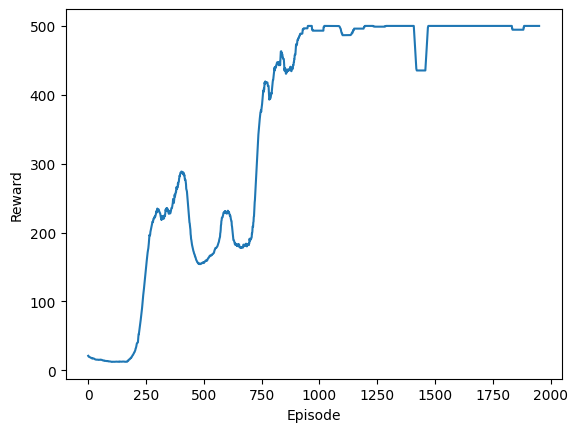

In [ ]:
win_size = 50
smoothed_rewards = np.convolve(episode_returns, np.ones(win_size)/win_size, mode='valid')
plt.plot(smoothed_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()